# (PRA)nalytics

## A study on the NBA's favorite production metric using Poisson Regression



Introduction

In basketball analytics, predicting a player’s overall game impact requires more than just focusing on scoring. Metrics such as Points + Rebounds + Assists (PRA) provide a broader measure of a player’s productivity, reflecting both offensive efficiency and involvement in team play. Because PRA is a count-based variable representing the total number of discrete events accumulated per game it naturally lends itself to Poisson regression modeling.

A Poisson model assumes that the number of occurrences of an event (in this case, PRA) follows a Poisson distribution, where the mean and variance are approximately equal. This approach is especially useful when dealing with right-skewed, non-negative data typical of game-level player statistics. By modeling PRA as a function of variables such as minutes played, field goal attempts, field goals made, shooting percentage, assists, and total rebounds, we can estimate the expected contribution of a player in any given game scenario.

The objective of this analysis is to develop a Poisson regression model that accurately predicts player PRA and evaluates how key performance factors influence production. Beyond statistical exploration, this model can serve practical real-world applications—from sports betting and fantasy projections to player workload management and performance forecasting. By quantifying the relationship between game metrics and total productivity, we can generate data-driven insights that enhance decision-making in both analytical and strategic basketball contexts.

In [1]:
install.packages("devtools")
devtools::install_github("abresler/nbastatR")


Installing package into 'C:/Users/Defte/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'devtools' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Defte\AppData\Local\Temp\RtmpUnF7oD\downloaded_packages



Please download and install Rtools 4.5 from https://cran.r-project.org/bin/windows/Rtools/.

Skipping install of 'nbastatR' from a github remote, the SHA1 (72fae070) has not changed since last install.
  Use `force = TRUE` to force installation



In [2]:
library(nbastatR)
library(dplyr)
library(tidyr)
library(ggplot2)

Warning message:
"replacing previous import 'curl::handle_reset' by 'httr::handle_reset' when loading 'nbastatR'"
Warning message:
"replacing previous import 'httr::timeout' by 'memoise::timeout' when loading 'nbastatR'"
Warning message:
"replacing previous import 'magrittr::set_names' by 'purrr::set_names' when loading 'nbastatR'"
Warning message:
"replacing previous import 'jsonlite::flatten' by 'purrr::flatten' when loading 'nbastatR'"
Warning message:
"replacing previous import 'curl::parse_date' by 'readr::parse_date' when loading 'nbastatR'"
Warning message:
"replacing previous import 'purrr::%@%' by 'rlang::%@%' when loading 'nbastatR'"
Warning message:
"replacing previous import 'purrr::flatten_lgl' by 'rlang::flatten_lgl' when loading 'nbastatR'"
Warning message:
"replacing previous import 'purrr::splice' by 'rlang::splice' when loading 'nbastatR'"
Warning message:
"replacing previous import 'purrr::flatten_chr' by 'rlang::flatten_chr' when loading 'nbastatR'"
Warning message:

# Load Data

In [3]:
Sys.setenv(VROOM_CONNECTION_SIZE = "33554432")

multi_season_logs <- game_logs(
  seasons = 2019:2024,   
  result_types = "player"
)

Warning message:
"The `x` argument of `as_tibble.matrix()` must have unique column names if
`.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.
ℹ The deprecated feature was likely used in the nbastatR package.
  Please report the issue at <https://github.com/abresler/nbastatR/issues>."
Warning message:
"Supplying `...` without names was deprecated in tidyr 1.0.0.
ℹ Please specify a name for each selection.
ℹ Did you want `data = -c(slugLeague, typeResult, slugSeason, yearSeason)`?
ℹ The deprecated feature was likely used in the nbastatR package.
  Please report the issue at <https://github.com/abresler/nbastatR/issues>."
Warning message:
"`cols` is now required when using `unnest()`.
ℹ Please use `cols = c(dataTables)`."


# Clean Data

In [4]:
colnames(multi_season_logs)

[1] "yearSeason"              "slugSeason"             
 [3] "slugLeague"              "typeSeason"             
 [5] "dateGame"                "idGame"                 
 [7] "numberGameTeamSeason"    "nameTeam"               
 [9] "idTeam"                  "isB2B"                  
[11] "isB2BFirst"              "isB2BSecond"            
[13] "locationGame"            "slugMatchup"            
[15] "slugTeam"                "countDaysRestTeam"      
[17] "countDaysNextGameTeam"   "slugOpponent"           
[19] "slugTeamWinner"          "slugTeamLoser"          
[21] "outcomeGame"             "namePlayer"             
[23] "numberGamePlayerSeason"  "countDaysRestPlayer"    
[25] "countDaysNextGamePlayer" "idPlayer"               
[27] "isWin"                   "fgm"                    
[29] "fga"                     "pctFG"                  
[31] "fg3m"                    "fg3a"                   
[33] "pctFG3"                  "pctFT"                  
[35] "hasVideo"                "fg2m"                   
[37] "fg2a"                    "pctFG2"                 
[39] "minutes"                 "ftm"                    
[41] "fta"                     "oreb"                   
[43] "dreb"                    "treb"                   
[45] "ast"                     "stl"                    
[47] "blk"                     "tov"                    
[49] "pf"                      "pts"                    
[51] "plusminus"               "fpts"                   
[53] "urlTeamSeasonLogo"       "urlPlayerStats"         
[55] "urlPlayerThumbnail"      "urlPlayerHeadshot"      
[57] "urlPlayerActionPhoto"    "urlPlayerPhoto"

In [5]:
nba_data <- multi_season_logs %>%
  select(slugSeason, idGame, dateGame, namePlayer, slugTeam, 
         slugOpponent, pts, treb, ast, minutes,countDaysRestTeam, fga, fgm, pctFG) 
  

In [6]:
head(nba_data)

slugSeason,idGame,dateGame,namePlayer,slugTeam,slugOpponent,pts,treb,ast,minutes,countDaysRestTeam,fga,fgm,pctFG
<chr>,<dbl>,<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-19,21800001,2018-10-16,Daniel Theis,BOS,PHI,0,1,0,4,120,0,0,NA
2018-19,21800002,2018-10-16,Klay Thompson,GSW,OKC,14,4,0,35,120,20,5,0.250
2018-19,21800002,2018-10-16,Draymond Green,GSW,OKC,2,13,5,33,120,6,1,0.167
2018-19,21800002,2018-10-16,Alfonzo McKinnie,GSW,OKC,0,0,0,2,120,1,0,0.000
2018-19,21800001,2018-10-16,JJ Redick,PHI,BOS,16,2,1,30,120,17,7,0.412
2018-19,21800001,2018-10-16,Landry Shamet,PHI,BOS,1,1,0,13,120,4,0,0.000


In [7]:
colSums(is.na(nba_data))

slugSeason            idGame          dateGame        namePlayer 
                0                 0                 0                 0 
         slugTeam      slugOpponent               pts              treb 
                0                 0                 0                 0 
              ast           minutes countDaysRestTeam               fga 
                0                 0                 0                 0 
              fgm             pctFG 
                0              7093

In [8]:
clean_data <- nba_data %>%
  mutate(
    pctFG = as.numeric(coalesce(pctFG, 0)),
    PRA = rowSums(across(c(pts, treb, ast), as.numeric), na.rm = TRUE)
  )


In [9]:
head(clean_data)

slugSeason,idGame,dateGame,namePlayer,slugTeam,slugOpponent,pts,treb,ast,minutes,countDaysRestTeam,fga,fgm,pctFG,PRA
<chr>,<dbl>,<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-19,21800001,2018-10-16,Daniel Theis,BOS,PHI,0,1,0,4,120,0,0,0.000,1
2018-19,21800002,2018-10-16,Klay Thompson,GSW,OKC,14,4,0,35,120,20,5,0.250,18
2018-19,21800002,2018-10-16,Draymond Green,GSW,OKC,2,13,5,33,120,6,1,0.167,20
2018-19,21800002,2018-10-16,Alfonzo McKinnie,GSW,OKC,0,0,0,2,120,1,0,0.000,0
2018-19,21800001,2018-10-16,JJ Redick,PHI,BOS,16,2,1,30,120,17,7,0.412,19
2018-19,21800001,2018-10-16,Landry Shamet,PHI,BOS,1,1,0,13,120,4,0,0.000,2


In [10]:
colSums(is.na(clean_data))

slugSeason            idGame          dateGame        namePlayer 
                0                 0                 0                 0 
         slugTeam      slugOpponent               pts              treb 
                0                 0                 0                 0 
              ast           minutes countDaysRestTeam               fga 
                0                 0                 0                 0 
              fgm             pctFG               PRA 
                0                 0                 0

# EDA

In [ ]:
install.packages('GGally')

Installing package into 'C:/Users/Defte/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'GGally' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Defte\AppData\Local\Temp\RtmpuADXKt\downloaded_packages


Numeric columns used for EDA: pts, treb, ast, minutes, fga, fgm, pctFG, PRA

Categorical columns considered: namePlayer, slugTeam, slugOpponent



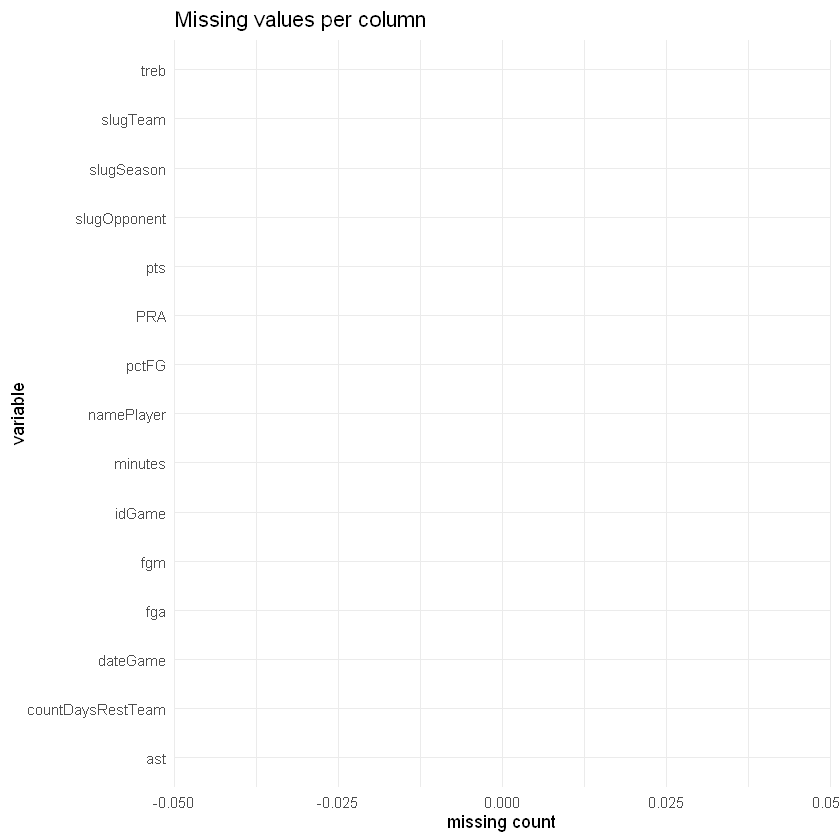

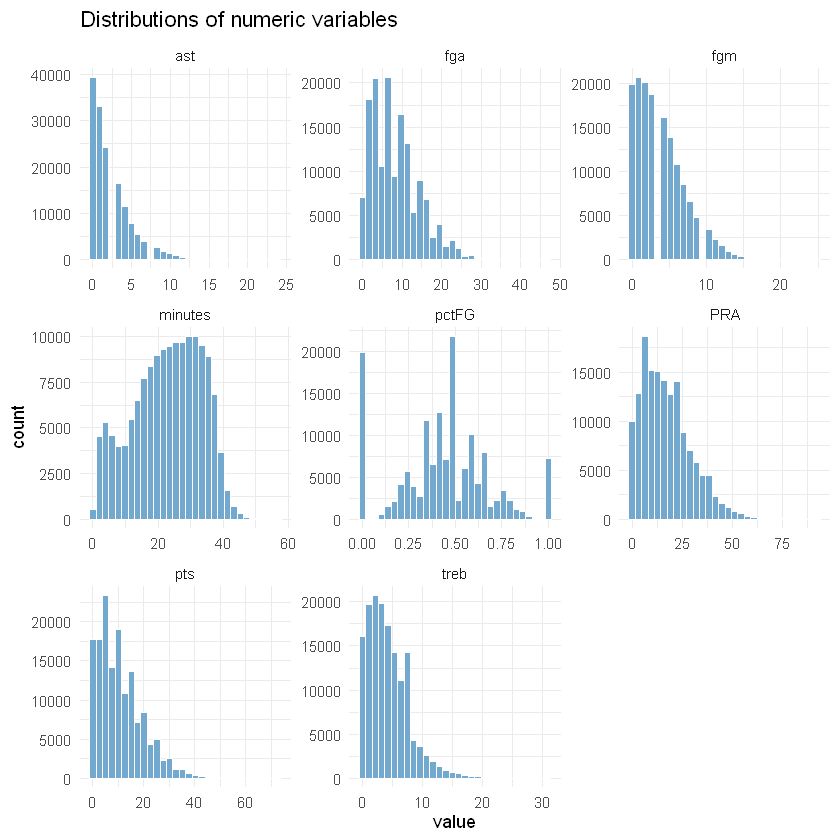

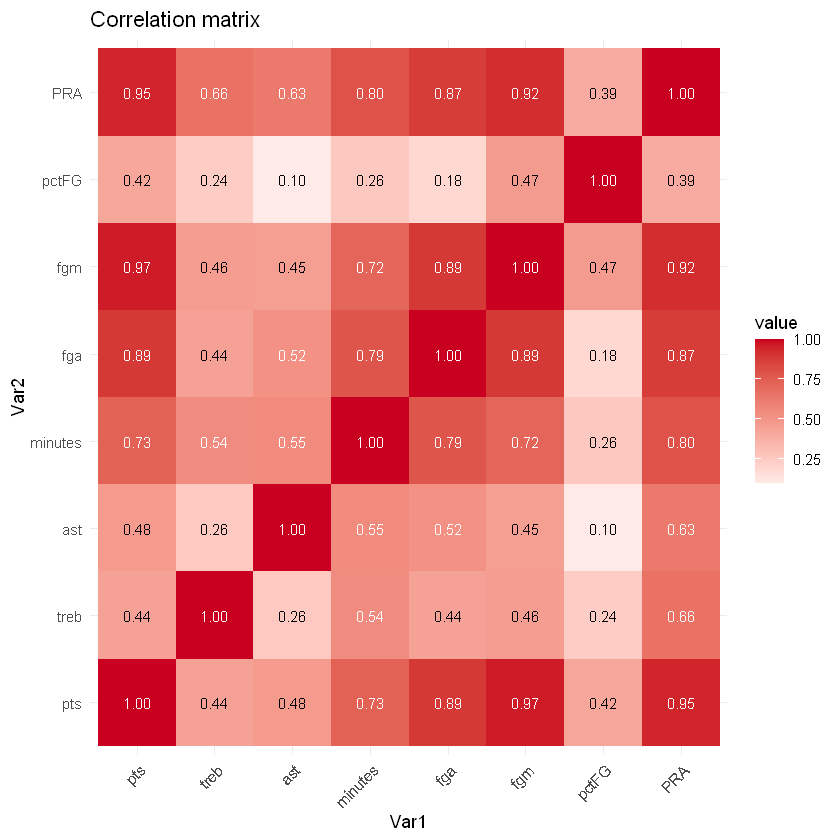

Warning message:
"`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information."
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


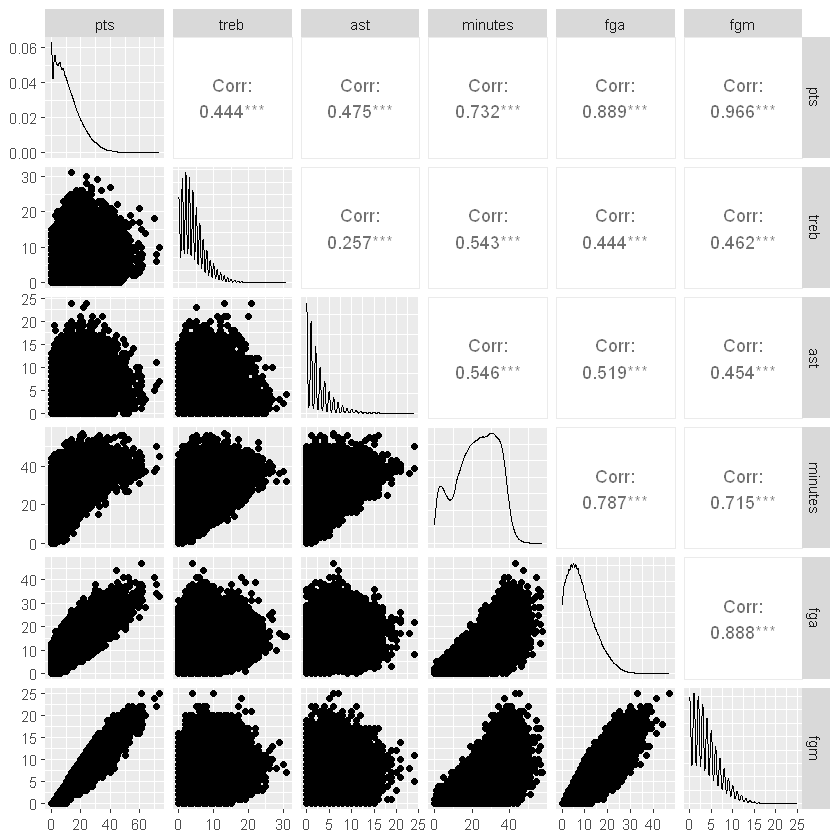

Saved EDA plots to: 



 [1] "reports/eda/actVsPred.png"          "reports/eda/actVsPredDist.png"     
 [3] "reports/eda/correlation_matrix.png" "reports/eda/distributions.png"     
 [5] "reports/eda/mean_PRA_time.png"      "reports/eda/missing_values.png"    
 [7] "reports/eda/namePlayer_top20.png"   "reports/eda/pairplot.png"          
 [9] "reports/eda/slugOpponent_top20.png" "reports/eda/slugTeam_top20.png"    
[11] "reports/eda/t20Performace.png"     


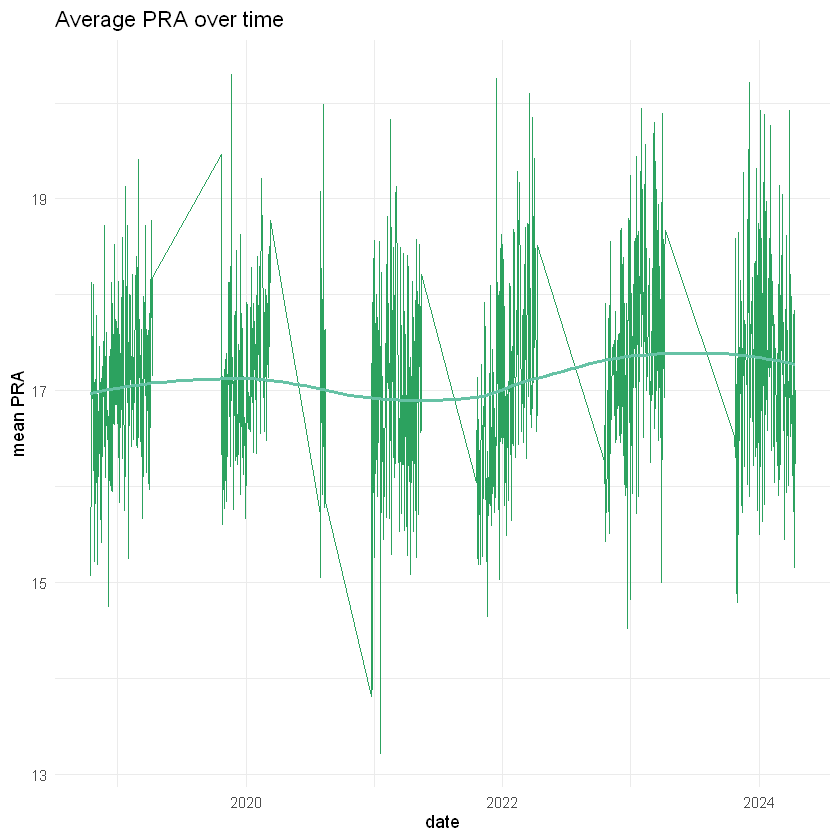

In [ ]:
# EDA: generate plots and save them to reports/eda/
# Creates ./reports/eda in the notebook working directory. Run this cell to produce PNGs.

out_dir <- file.path("reports","eda")
dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)



# Ensure PRA exists
if(!"PRA" %in% names(clean_data)){
  clean_data <- clean_data %>% mutate(PRA = rowSums(across(c(pts, treb, ast)), na.rm = TRUE))
}

num_cols <- c("pts","treb","ast","minutes","fga","fgm","pctFG","PRA")
num_cols <- intersect(names(clean_data), num_cols)

cat_cols <- intersect(names(clean_data), c("slugTeam","slugOpponent","namePlayer"))

message("Numeric columns used for EDA: ", paste(num_cols, collapse = ", "))
message("Categorical columns considered: ", paste(cat_cols, collapse = ", "))

# 1) Missing values per column
missing_df <- sapply(clean_data, function(x) sum(is.na(x)))
missing_df <- data.frame(variable = names(missing_df), missing = as.integer(missing_df), row.names = NULL)

p_missing <- ggplot(missing_df, aes(x = reorder(variable, -missing), y = missing)) +
  geom_col(fill = "#2b8cbe") +
  coord_flip() +
  labs(title = "Missing values per column", x = "variable", y = "missing count") +
  theme_minimal()

ggsave(filename = file.path(out_dir, "missing_values.png"), plot = p_missing, width = 8, height = 6)
print(p_missing)

# 2) Distributions for numeric columns (faceted)
if(length(num_cols) > 0){
  dist_df <- clean_data %>% select(all_of(num_cols)) %>% pivot_longer(everything(), names_to = "variable", values_to = "value")
  p_dist <- ggplot(dist_df, aes(x = value)) +
    geom_histogram(bins = 30, fill = "#74a9cf", color = "white") +
    facet_wrap(~variable, scales = "free") +
    labs(title = "Distributions of numeric variables") +
    theme_minimal()
  ggsave(filename = file.path(out_dir, "distributions.png"), plot = p_dist, width = 12, height = 8)
  print(p_dist)
}

# 3) Correlation matrix heatmap (with numeric labels)
if(length(num_cols) >= 2){
  numeric_mat <- clean_data %>% select(all_of(num_cols))
  cor_mat <- cor(na.omit(numeric_mat), use = "pairwise.complete.obs")
  cor_df <- as.data.frame(as.table(cor_mat))
  names(cor_df) <- c("Var1","Var2","value")
  # formatted labels and contrasting text color depending on magnitude
  cor_df$label <- sprintf("%.2f", cor_df$value)
  cor_df$label_col <- ifelse(abs(cor_df$value) > 0.5, "white", "black")

  p_cor <- ggplot(cor_df, aes(x = Var1, y = Var2, fill = value)) +
    geom_tile() +
    geom_text(aes(label = label, color = label_col), size = 3.2) +
    scale_color_identity() +
    scale_fill_gradient2(low = "#0571b0", mid = "white", high = "#ca0020", midpoint = 0) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(title = "Correlation matrix")

  ggsave(filename = file.path(out_dir, "correlation_matrix.png"), plot = p_cor, width = 6, height = 6)
  print(p_cor)
}

# 4) Pairplot (GGally) if available
if(requireNamespace("GGally", quietly = TRUE) & length(num_cols) >= 2){
  # try to reduce to a reasonable number of columns for pairplot
  pp_cols <- head(num_cols, 6)
  p_pairs <- GGally::ggpairs(na.omit(clean_data[pp_cols]))
  ggsave(filename = file.path(out_dir, "pairplot.png"), plot = p_pairs, width = 12, height = 12)
  print(p_pairs)
} else {
  message("GGally not available or not enough numeric columns — skipping pairplot. To enable, install.packages('GGally')")
}

# 5) Top categorical counts (top 20)
if(length(cat_cols) > 0){
  for(col in cat_cols){
    topn <- clean_data %>% group_by_at(col) %>% summarise(n = n()) %>% arrange(desc(n)) %>% head(20)
    p_cat <- ggplot(topn, aes_string(x = col, y = "n")) +
      geom_col(fill = "#f46d43") +
      coord_flip() +
      labs(title = paste0("Top 20: ", col), x = col, y = "count") +
      theme_minimal()
    ggsave(filename = file.path(out_dir, paste0(col, "_top20.png")), plot = p_cat, width = 8, height = 6)
  }
}

# 6) Time series: mean PRA over time
if("dateGame" %in% names(clean_data)){
  # try to coerce to Date
  if(!inherits(clean_data$dateGame, "Date")){
    clean_data$dateGame <- as.Date(clean_data$dateGame)
  }
  if(inherits(clean_data$dateGame, "Date")){
    ts_df <- clean_data %>% group_by(dateGame) %>% summarise(mean_PRA = mean(PRA, na.rm = TRUE), games = n())
    p_ts <- ggplot(ts_df, aes(x = dateGame, y = mean_PRA)) +
      geom_line(color = "#2ca25f") +
      geom_smooth(method = "loess", se = FALSE, color = "#66c2a5") +
      labs(title = "Average PRA over time", x = "date", y = "mean PRA") +
      theme_minimal()
    ggsave(filename = file.path(out_dir, "mean_PRA_time.png"), plot = p_ts, width = 10, height = 4)
    print(p_ts)
  } else {
    message("dateGame exists but couldn't coerce to Date — skipping time series")
  }
}

# List saved files
message("Saved EDA plots to: ")
print(list.files(out_dir, full.names = TRUE))


Distributions (the histograms)

Right-skewed counts: Points (pts), rebounds (treb), assists (ast), shot attempts (fga), and makes (fgm) all cluster near zero and taper right typical of count data. This justifies using a Poisson or Negative Binomial framework.

Minutes: Roughly bell-shaped but slightly right-skewed, peaking around 25–30 minutes, which fits normal player rotation patterns (bench → starters → stars).

pctFG: Bimodal with clusters near 0 and 1 from players who barely shot (0% or 100%). Between those extremes, it centers around 0.45–0.55, which is realistic league-wide efficiency.

PRA: Strongly right-skewed; most players have modest totals, a few have massive games. 

Correlation matrix 

Extremely high correlations among scoring variables:
pts, fgm, and fga have correlations above 0.85–0.95 — almost redundant. That means you don’t want to include all three raw in the same model, or you’ll get multicollinearity (inflated standard errors).

PRA correlation patterns:
Strongly correlated with fgm, fga, and minutes (0.8–0.9). Those are your dominant predictors.
Moderate correlation with ast and treb (0.6–0.7), confirming they meaningfully contribute but aren’t perfectly redundant.
Weak correlation with pctFG (≈0.4), showing that efficiency helps but isn’t the main driver volume matters more.

Minutes as a key bridge variable:
Moderately correlated with nearly everything (≈0.7–0.8). That’s logical playing time amplifies every other counting stat.

Pairwise scatterplots 
Clear positive relationships: PRA-related metrics all move together more minutes more attempts more makes more PRAs.
Nonlinear patterns:
The curved shapes between minutes and fga/fgm suggest diminishing returns: after ~35 minutes, production plateaus.
Similar soft curvature between fga and pts, hinting efficiency declines with extreme shot volume.
Assists and rebounds show weaker relationships with shooting stats they behave more independently, which supports including them as distinct predictors.
No visible outlier clusters or weird breaks, so data quality looks solid.

# AVG PRA (curious)

In [11]:
player_season_avg <- clean_data %>%
  group_by(namePlayer, slugSeason) %>%
  summarise(
    games_played = n(),
    avg_pts = mean(pts, na.rm = TRUE),
    avg_reb = mean(treb, na.rm = TRUE),
    avg_ast = mean(ast, na.rm = TRUE),
    avg_min = mean(minutes, na.rm = TRUE),
    avg_fga = mean(fga, na.rm = TRUE),
    avg_fgm = mean(fgm, na.rm = TRUE),
    avg_pctFG = mean(pctFG, na.rm = TRUE),
    avg_pra = mean(PRA, na.rm = TRUE),
    .groups = "drop"
  )

In [12]:
head(player_season_avg)

namePlayer,slugSeason,games_played,avg_pts,avg_reb,avg_ast,avg_min,avg_fga,avg_fgm,avg_pctFG,avg_pra
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A.J. Lawson,2022-23,15,3.733333,1.400000,0.1333333,7.266667,2.933333,1.466667,0.3778000,5.266667
A.J. Lawson,2023-24,42,3.238095,1.190476,0.4761905,7.476190,2.880952,1.285714,0.3810238,4.904762
AJ Green,2022-23,35,4.400000,1.285714,0.6285714,9.857143,3.571429,1.514286,0.2605429,6.314286
AJ Green,2023-24,56,4.500000,1.142857,0.5357143,10.964286,3.500000,1.482143,0.3598036,6.178571
AJ Griffin,2022-23,72,8.875000,2.125000,1.0138889,19.402778,7.402778,3.444444,0.4582083,12.013889
AJ Griffin,2023-24,20,2.400000,0.900000,0.2500000,8.500000,3.100000,0.900000,0.3059500,3.550000


# Look for Overdispersion

In [13]:
mean(clean_data$PRA)
var(clean_data$PRA)




[1] 17.12657

[1] 147.4953

Overdispersion happens when the variance of your data is larger than the mean

In a perfect Poisson world, the mean (μ) and variance (σ²) are supposed to be equal:

In [14]:
# Fit a Poisson regression model (m_pra) to predict a player's PRA (points + rebounds + assists)
# using several predictor variables: minutes played, points, rebounds (treb), assists, 
# field goal attempts (fga), and field goals made (fgm). 
# The 'family = poisson' argument specifies that the response variable follows a Poisson distribution 
# suitable for modeling count-type data. 
# After fitting the model, run 'dispersiontest(m_pra)' to check for overdispersion—i.e., 
# whether the variance of PRA is significantly greater than its mean, which would suggest that 
# a quasi-Poisson or negative binomial model might be more appropriate.



if(!requireNamespace("AER", quietly = TRUE)){
  install.packages("AER")
}
library(AER)

m_pra <- glm( PRA ~ minutes + pts + treb + ast + fga + fgm, data = clean_data, family = poisson)
dispersiontest(m_pra)


Warning message:
"package 'AER' was built under R version 4.5.2"
Loading required package: car

Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


Loading required package: lmtest

Warning message:
"package 'lmtest' was built under R version 4.5.2"
Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: sandwich

Warning message:
"package 'sandwich' was built under R version 4.5.2"
Loading required package: survival




	Overdispersion test

data:  m_pra
z = 12.135, p-value < 2.2e-16
alternative hypothesis: true dispersion is greater than 1
sample estimates:
dispersion 
   1.06242 


 The dispersion test evaluates whether the variance in the Poisson model (m_pra) 
 is significantly greater than the mean a key assumption of Poisson regression.
 
 Results:
  z = 12.135, p-value < 2.2e-16
  estimated dispersion = 1.062

Interpretation:
The p-value is extremely small, indicating statistically significant overdispersion 
(variance exceeds the mean). However, the estimated dispersion value (1.06) 
is very close to 1, suggesting that the overdispersion is minimal and the standard 
Poisson model still provides an adequate fit. No need to switch to quasi-Poisson or 
negative binomial unless further residual checks show systematic patterns.

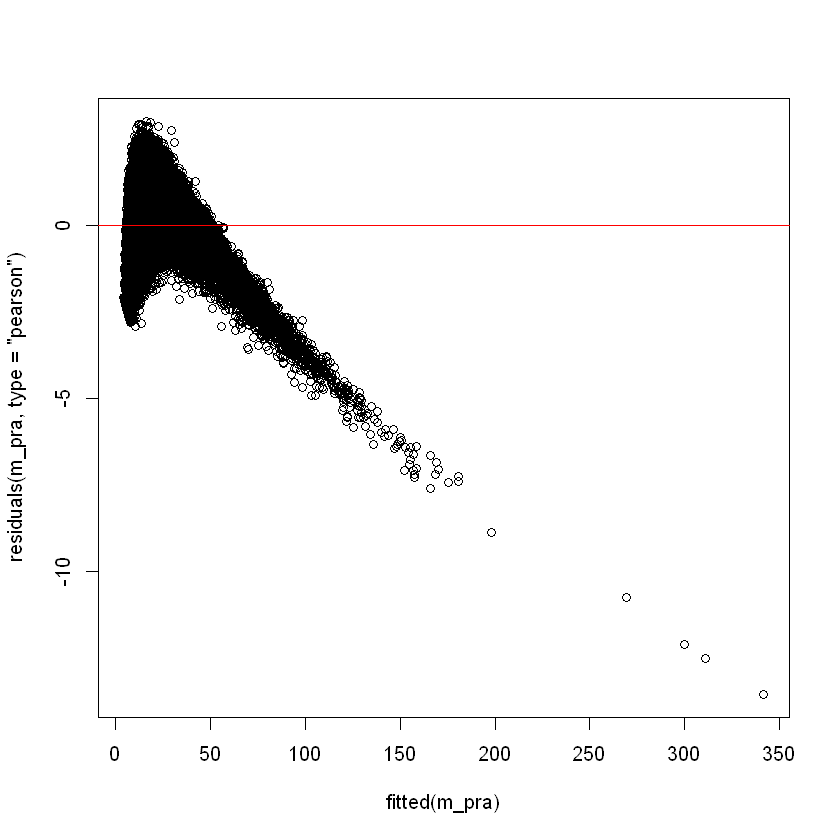

In [15]:
plot(fitted(m_pra), residuals(m_pra, type = "pearson"))
abline(h = 0, col = "red")

This plot shows Pearson residuals versus fitted values for the Poisson regression model (m_pra).

 Interpretation:
 - The residuals form a clear downward curve rather than scattering randomly around zero.
 - This pattern indicates systematic bias: the model underestimates low PRA values and 
   overestimates high PRA values.
 - Even though the dispersion estimate (1.06) is near 1, the residual structure suggests 
   the Poisson assumption (equal mean and variance) doesn’t hold consistently across fitted values.

 Conclusion:
 The model may not fully capture the relationship between predictors and PRA. 
 Consider using a quasi-Poisson or negative binomial model to allow more flexible variance, 
 or test nonlinear effects (e.g., squared minutes or interaction terms) to better fit the data.

# Partition Data into Trainning and Testing

In [16]:
set.seed(123)  # for reproducibility

#Temporal Validation
train_seasons <- c("2018-19", "2019-20", "2020-21", "2021-22", "2022-23")
test_seasons  <- c("2023-24")

# partition data
train_data <- clean_data %>%
  filter(slugSeason %in% train_seasons)

test_data <- clean_data %>%
  filter(slugSeason %in% test_seasons)

In [17]:
train_data

slugSeason,idGame,dateGame,namePlayer,slugTeam,slugOpponent,pts,treb,ast,minutes,countDaysRestTeam,fga,fgm,pctFG,PRA
<chr>,<dbl>,<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-19,21800001,2018-10-16,Daniel Theis,BOS,PHI,0,1,0,4,120,0,0,0.000,1
2018-19,21800002,2018-10-16,Klay Thompson,GSW,OKC,14,4,0,35,120,20,5,0.250,18
2018-19,21800002,2018-10-16,Draymond Green,GSW,OKC,2,13,5,33,120,6,1,0.167,20
2018-19,21800002,2018-10-16,Alfonzo McKinnie,GSW,OKC,0,0,0,2,120,1,0,0.000,0
2018-19,21800001,2018-10-16,JJ Redick,PHI,BOS,16,2,1,30,120,17,7,0.412,19
2018-19,21800001,2018-10-16,Landry Shamet,PHI,BOS,1,1,0,13,120,4,0,0.000,2
2018-19,21800002,2018-10-16,Raymond Felton,OKC,GSW,6,3,1,14,120,5,1,0.200,10
2018-19,21800001,2018-10-16,Brad Wanamaker,BOS,PHI,2,1,0,1,120,1,1,1.000,3
2018-19,21800001,2018-10-16,Aron Baynes,BOS,PHI,8,4,3,19,120,7,3,0.429,15


In [18]:
test_data

slugSeason,idGame,dateGame,namePlayer,slugTeam,slugOpponent,pts,treb,ast,minutes,countDaysRestTeam,fga,fgm,pctFG,PRA
<chr>,<dbl>,<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2023-24,22300061,2023-10-24,Reggie Jackson,DEN,LAL,8,3,1,24,120,8,3,0.375,12
2023-24,22300061,2023-10-24,Aaron Gordon,DEN,LAL,15,7,5,35,120,11,7,0.636,27
2023-24,22300061,2023-10-24,Nikola Jokić,DEN,LAL,29,13,11,36,120,22,12,0.545,53
2023-24,22300061,2023-10-24,Michael Porter Jr.,DEN,LAL,12,12,2,30,120,13,5,0.385,26
2023-24,22300061,2023-10-24,Jalen Pickett,DEN,LAL,2,0,0,1,120,1,1,1.000,2
2023-24,22300061,2023-10-24,Braxton Key,DEN,LAL,0,0,0,1,120,0,0,0.000,0
2023-24,22300061,2023-10-24,Collin Gillespie,DEN,LAL,0,0,0,1,120,0,0,0.000,0
2023-24,22300062,2023-10-24,Klay Thompson,GSW,PHX,15,7,3,36,120,18,6,0.333,25
2023-24,22300062,2023-10-24,Dario Šarić,GSW,PHX,7,7,1,20,120,11,3,0.273,15


dependent variable is PRA = points + rebounds + assists.
If you include pts as a predictor, you’re feeding part of your target variable into the model. That’s a textbook case of data leakage the model “learns” to predict PRA from something it already contains.

In [19]:
# Poisson regression with nonlinear and interaction effects
m_pra_poly_interact <- glm(
  PRA ~ 
    minutes + I(minutes^2) +           # nonlinear effect of playing time
    fga + I(fga^2) +                   # nonlinear effect of shot volume
    pctFG * fga +                      # interaction: shot volume × shooting efficiency
    ast + treb +                       # core predictors
    minutes:fga +                      # more minutes amplify effect of shot volume
    fgm:ast,                         # synergy between scoring and playmaking
  data = train_data,
  family = poisson
)

In [20]:
summary(m_pra_poly_interact)


Call:
glm(formula = PRA ~ minutes + I(minutes^2) + fga + I(fga^2) + 
    pctFG * fga + ast + treb + minutes:fga + fgm:ast, family = poisson, 
    data = train_data)

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   3.205e-01  5.804e-03   55.22   <2e-16 ***
minutes       6.534e-02  5.639e-04  115.88   <2e-16 ***
I(minutes^2) -9.148e-04  1.511e-05  -60.55   <2e-16 ***
fga           9.299e-02  9.370e-04   99.24   <2e-16 ***
I(fga^2)     -1.135e-03  2.424e-05  -46.83   <2e-16 ***
pctFG         9.025e-01  6.159e-03  146.53   <2e-16 ***
ast           6.812e-02  5.844e-04  116.56   <2e-16 ***
treb          3.696e-02  1.905e-04  194.00   <2e-16 ***
fga:pctFG     3.176e-02  7.434e-04   42.72   <2e-16 ***
minutes:fga  -5.300e-04  3.682e-05  -14.39   <2e-16 ***
ast:fgm      -4.064e-03  7.633e-05  -53.24   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 109

In [21]:
exp(cbind(Estimate = coef(m_pra_poly_interact), confint(m_pra_poly_interact)))


Waiting for profiling to be done...



,Estimate,2.5 %,97.5 %
(Intercept),1.3778273,1.3622287,1.3935779
minutes,1.0675268,1.0663482,1.0687078
I(minutes^2),0.9990856,0.9990560,0.9991151
fga,1.0974485,1.0954348,1.0994658
I(fga^2),0.9988655,0.9988180,0.9989129
pctFG,2.4657039,2.4361178,2.4956479
ast,1.0704918,1.0692661,1.0717184
treb,1.0376484,1.0372609,1.0380358
fga:pctFG,1.0322674,1.0307643,1.0337724
minutes:fga,0.9994702,0.9993981,0.9995423


| Variable    | Coefficient (β) |      exp(β) | Interpretation                                                                                                                          |
| ----------- | --------------: | ----------: | --------------------------------------------------------------------------------------------------------------------------------------- |
| (Intercept) |          0.3205 |       1.377 | Baseline expected PRA ≈ 1.38 when all predictors are 0 (not meaningful on its own).                                                     |
| minutes     |         0.06534 |  **1.0675** | Each additional minute increases expected PRA by about **6.8%**.                                                                        |
| I(minutes²) |      -0.0009148 | **0.99909** | Small **diminishing return**: as playing time increases, the gain in PRA per extra minute slightly decreases.                           |
| fga         |         0.09299 |  **1.0974** | Each extra field-goal attempt raises expected PRA by **~9.7%**.                                                                         |
| I(fga²)     |       -0.001135 | **0.99887** | More shot attempts eventually yield smaller incremental gains (diminishing returns).                                                    |
| pctFG       |          0.9025 |   **2.466** | A full 1.0 increase in field-goal percentage (from 0 to 1) would more than double PRA; practically, a 0.10 (10%) rise ≈ **+10% PRA**.   |
| ast         |         0.06812 |  **1.0704** | Each additional assist increases expected PRA by **~7.0%**.                                                                             |
| treb        |         0.03696 |  **1.0377** | Each additional rebound increases expected PRA by **~3.8%**.                                                                            |
| fga:pctFG   |         0.03176 |  **1.0323** | For players who take more shots *and* shoot efficiently, PRA rises an extra **3.2% per joint increase**—synergistic effect.             |
| minutes:fga |        -0.00053 | **0.99947** | Slight **negative interaction**: the impact of shot attempts shrinks slightly as minutes rise (fatigue or usage saturation).            |
| ast:fgm     |        -0.00406 | **0.99595** | Negative trade-off: as assists and made field goals both increase, total PRA rises less than expected (scoring vs playmaking tradeoff). |


Summary Interpretation

The largest driver of PRA is minutes, followed by field-goal attempts and shooting efficiency.

Both minutes² and FGA² confirm diminishing returns — production increases taper off with extreme playing time or shot volume.

The positive fga:pctFG interaction rewards efficient, high-volume shooters (the Steph Curry effect).

The negative minutes:fga and ast:fgm interactions reveal workload and role trade-offs between scoring and assisting.


Poisson Regression Summary — Predicting Player PRA (Points + Rebounds + Assists)

Model Overview:
This Poisson regression models a player's total PRA in a game as a function of
minutes played, field goal attempts (FGA), field goal percentage (pctFG),
assists, rebounds, and several interaction/nonlinear terms.
The inclusion of squared and interaction terms allows the model to capture
diminishing returns and synergistic effects between key performance factors.



Model Fit:
- Null deviance: 1,092,752 → Residual deviance: 77,414
    Indicates a strong reduction in unexplained variance the predictors explain
    much of the variability in PRA.
- Dispersion parameter ≈ 1 → Poisson variance assumption holds reasonably well.
- AIC: 606,403 → Useful for comparing against simpler or alternative models.


Interpretation Summary:
PRA is primarily driven by minutes, shot volume, and shooting efficiency,
with diminishing returns at higher values. Efficient high-volume shooters
and balanced playmakers produce the highest PRA. However, the trade-offs
between scoring and assisting are clearly visible in the negative interactions.
Overall, this model provides a statistically robust and interpretable
framework for explaining game-level player productivity.

In [22]:
test_data$predicted_PRA <- predict(m_pra_poly_interact, newdata = test_data, type = "response")

# basic evaluation
cor <- cor(test_data$PRA, test_data$predicted_PRA)               # correlation between actual & predicted
MAE <- mean(abs(test_data$PRA - test_data$predicted_PRA))        # mean absolute error
MSE <- sqrt(mean((test_data$PRA - test_data$predicted_PRA)^2))   # root mean squared error


# Mean percentage error and mean absolute percentage error
filtered <- test_data[test_data$PRA != 0, ]
MPE <- mean((filtered$PRA - filtered$predicted_PRA) / filtered$PRA)
MAPE <- mean(abs(filtered$PRA - filtered$predicted_PRA) / filtered$PRA)

print(paste("Correlation:", round(cor, 4)))
print(paste("Mean Absolute Error (MAE):", round(MAE, 4)))
print(paste("Root Mean Squared Error (RMSE):", round(MSE, 4)))
print(paste("Mean Percentage Error (MPE):", round(MPE, 4)))
print(paste("Mean Absolute Percentage Error (MAPE):", round(MAPE, 4)))


[1] "Correlation: 0.9715"
[1] "Mean Absolute Error (MAE): 2.1471"
[1] "Root Mean Squared Error (RMSE): 3.0048"
[1] "Mean Percentage Error (MPE): -0.0707"
[1] "Mean Absolute Percentage Error (MAPE): 0.1987"


Correlation: 0.9715
This is the Pearson correlation between actual and predicted PRA values.
It measures how well the two move together (direction and strength of linear relationship).
A value of 0.97 is extremely high — almost a perfect linear relationship.
The model captures nearly all of the variation in PRA across players and games.
In human terms: when actual PRA goes up, your predicted PRA goes up almost exactly in step.

Mean Absolute Error (MAE): 2.15
This tells you the average absolute difference between actual and predicted PRA.
On average, the model misses by about 2 PRA units — which is tiny given that typical game totals are in the 20–40 range.
That’s like predicting a player will get 31 PRA, and they end up with 33 easily within normal game-to-game noise.

Root Mean Squared Error (RMSE): 3.00
RMSE punishes larger errors more heavily (because it squares them before averaging).
An RMSE of 3.0 means the typical prediction is within ±3 PRA points of reality.
Since PRA ranges roughly from 0 to 70+, that’s about a 5% relative error extremely accurate for sports data.

Mean Percentage Error (MPE): -0.0707 → On average, predictions are about 7.1% lower than the true PRA values. The negative sign means the model slightly underpredicts player performances overall.

Mean Absolute Percentage Error (MAPE): 0.1987 → After removing direction (positive/negative), the average error magnitude is about 19.9%. That means your typical prediction is within roughly ±20% of the actual PRA

Overall interpretation

-Tracks PRA variation very closely (correlation 0.97)

-Predicts with minimal average error (MAE ≈ 2)

-Rarely makes large mistakes (RMSE ≈ 3)

-The only consistent weakness — as seen in future plot is underestimating extreme performances, but even that’s minor.



In [ ]:
head(test_data)

slugSeason,idGame,dateGame,namePlayer,slugTeam,slugOpponent,pts,treb,ast,minutes,countDaysRestTeam,fga,fgm,pctFG,PRA,predicted_PRA
<chr>,<dbl>,<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2023-24,22300061,2023-10-24,Reggie Jackson,DEN,LAL,8,3,1,24,120,8,3,0.375,12,12.576465
2023-24,22300061,2023-10-24,Aaron Gordon,DEN,LAL,15,7,5,35,120,11,7,0.636,27,30.617520
2023-24,22300061,2023-10-24,Nikola Jokić,DEN,LAL,29,13,11,36,120,22,12,0.545,53,62.166841
2023-24,22300061,2023-10-24,Michael Porter Jr.,DEN,LAL,12,12,2,30,120,13,5,0.385,26,27.475235
2023-24,22300061,2023-10-24,Jalen Pickett,DEN,LAL,2,0,0,1,120,1,1,1.000,2,4.097985
2023-24,22300061,2023-10-24,Braxton Key,DEN,LAL,0,0,0,1,120,0,0,0.000,0,1.469522


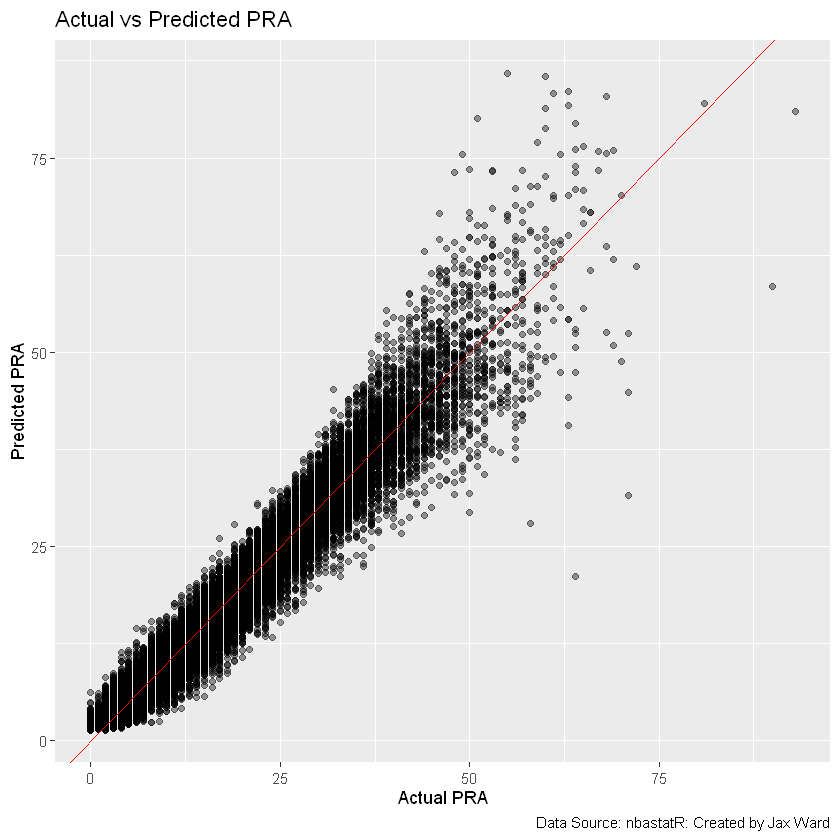

In [ ]:

actVsPred <- ggplot(test_data, aes(x = PRA, y = predicted_PRA)) +
  geom_point(alpha = 0.4) +
  geom_abline(color = "red") +
  labs(title = "Actual vs Predicted PRA",
      caption = "Data Source: nbastatR: Created by Jax Ward",
       x = "Actual PRA", y = "Predicted PRA")
ggsave(filename = file.path(out_dir, "actVsPred.png"), plot = actVsPred, width = 8, height = 6)
print(actVsPred)

Strong overall alignment.
The points tightly hug the red line up to about 40–50 PRA, showing that the model predicts typical game outcomes quite accurately. It’s capturing the main drivers (minutes, FGA, FG%, etc.) well.

Slight underestimation at high PRA.
For very high actual values (above ~50), the points drift below the line — meaning the model tends to underpredict elite performances.
Poisson models often struggle with extreme counts because variance grows faster than the mean.

Minor spread at lower PRA.
Near the origin, the scatter widens a bit, suggesting more unpredictability for low-usage or bench players (small-sample volatility).

No glaring systematic bias mid-range.
Between 10 and 40 PRA, predictions cluster symmetrically around the line that’s the model’s sweet spot.

Warning message:
"The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead."


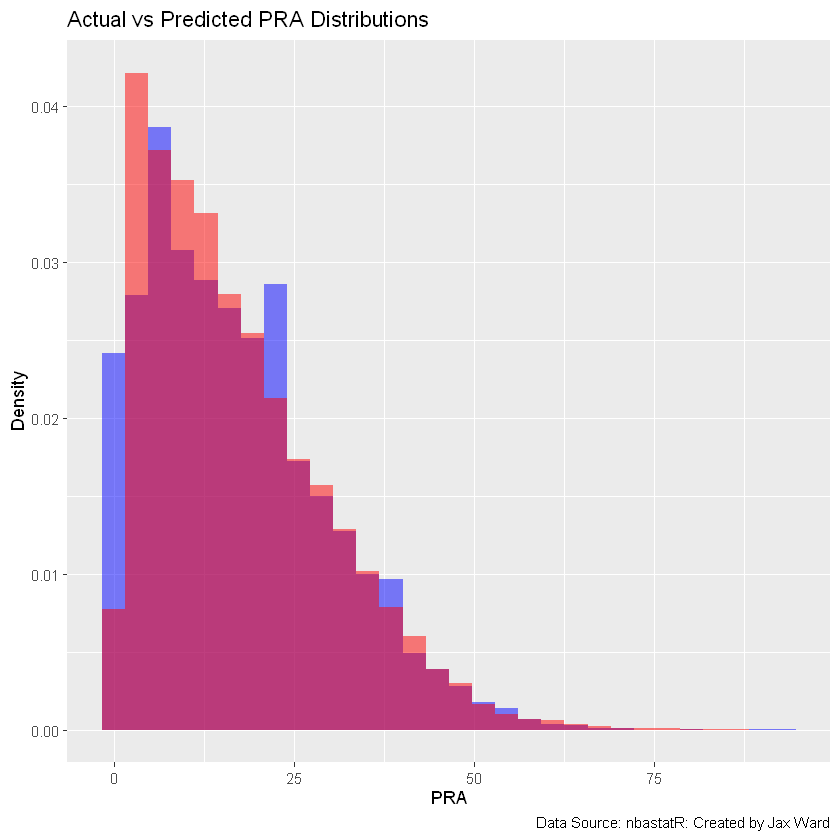

In [ ]:
actVsPredDist <- ggplot() +
  geom_histogram(data = test_data, aes(x = PRA, y = ..density..),
                 fill = "blue", alpha = 0.5, bins = 30) +
  geom_histogram(data = test_data, aes(x = predicted_PRA, y = ..density..),
                 fill = "red", alpha = 0.5, bins = 30) +
  labs(title = "Actual vs Predicted PRA Distributions",
      caption = "Data Source: nbastatR: Created by Jax Ward",
       x = "PRA", y = "Density")
ggsave(filename = file.path(out_dir, "actVsPredDist.png"), width = 8, height = 6)
print(actVsPredDist)

This plot compares the distribution of actual vs. model-predicted PRA values. Both follow a similar right-skewed shape, which means the model captures the overall structure of game outcomes pretty well.

Key points:
The two histograms almost overlap (red for predicted, blue for actual). That overlap most visible around 5 – 30 PRA shows the model’s predicted range and density match the true data closely.
The model slightly underestimates extreme games: the blue tail extends a bit further to the right, meaning real players occasionally post bigger PRA totals than the model expects.
At the low end (PRA ≈ 0–5), the blue bars edge above the red, suggesting the model predicts less low-output games than occur in reality.

The overall shape a tall peak near 10–15 followed by a gradual drop confirms that PRA behaves like count data with heavy skew, consistent with the Poisson framework


In [23]:
test_data$performance_diff <- test_data$PRA - test_data$predicted_PRA

# Calculate top 20 overperformers
player_perf <- test_data %>%
  group_by(namePlayer) %>%
  summarise(mean_diff = mean(performance_diff, na.rm = TRUE)) %>%
  arrange(desc(mean_diff)) %>%
  slice_head(n = 20)

# Bar chart with labels and red bars
t20Performace <- ggplot(player_perf, aes(x = reorder(namePlayer, mean_diff), y = mean_diff)) +
  geom_bar(stat = "identity", fill = "red") +
  geom_text(aes(label = round(mean_diff, 2)), 
            hjust = -0.1, 
            size = 3.5, 
            color = "black") +
  coord_flip() +
  labs(
    title = "Top 20 Players Who Outperformed Model Expectations",
    subtitle = "Based on Average Performance Difference (Actual - Predicted PRA) in 2023-24 Season",
    caption = "Data Source: nbastatR: Created by Jax Ward",
    x = "Player",
    y = "Average Performance Difference (Actual - Predicted PRA)"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14, hjust = 0.5),
    plot.subtitle = element_text(size = 12, hjust = 0.5),
    axis.text.y = element_text(size = 10)
  ) +
  expand_limits(y = max(player_perf$mean_diff) * 1.1)
  ggsave(filename = file.path(out_dir, "t20Performace.png"), plot = t20Performace, width = 8, height = 6)
print(t20Performace)

ERROR: Error: object 'out_dir' not found


Bars on the graph show players who routinely overperformed the model’s predictions.

The longer the bar, the more they exceeded expectations making good candidates for model refinement or “underrated” status in real-world terms.

# EV Exercise

In [24]:
new_game <- data.frame(
  minutes = 35, fga = 20, fgm = 10,
  ast = 7, treb = 8, pts = 16, pctFG = 0.52
) # hypothetical new game scenario using a PRA line of 33.5

# Poisson model
lambda <- predict(m_pra, newdata = new_game, type = "response")

In [25]:
lambda # predicted PRA for the new game scenario

1 
31.15768

In [26]:
prob_over_poisson <- function(lambda, line){
  if (line %% 1 == 0) {        # whole-number line (push possible)
    p_over <- 1 - ppois(line, lambda)
    p_push <- dpois(line, lambda)
  } else {                     # half-point line (no push)
    p_over <- 1 - ppois(floor(line), lambda)
    p_push <- 0
  }
  list(p_over = p_over, p_push = p_push, p_under = 1 - p_over - p_push)
}
po <- prob_over_poisson(lambda, 33.5)

In [27]:
po

$p_over
[1] 0.3284754

$p_push
[1] 0

$p_under
[1] 0.6715246

In [28]:
profit_if_win_from_american <- function(american){
  if (american > 0) american/100 else 100/abs(american)
}

ev_over <- function(p_over, p_push, american_odds, stake = 1){
  win_profit <- profit_if_win_from_american(american_odds) * stake
  p_loss <- 1 - p_over - p_push
  # EV = p(win)*profit  - p(loss)*stake + p(push)*0
  p_over * win_profit - p_loss * stake
}

ev_under <- function(p_under, p_push, american_odds, stake = 1){
  win_profit <- profit_if_win_from_american(american_odds) * stake
  p_loss <- 1 - p_under - p_push
  p_under * win_profit - p_loss * stake
}

EV = (Probability of Winning × Profit per Bet) − (Probability of Losing × Stake)

This means you multiply your chance of winning by the profit per dollar and subtract the chance of losing times your stake. If EV is greater than zero, the bet is theoretically profitable in the long run; if it’s less than zero, it has a negative expectation and would lose money over time.

In [29]:
p <- prob_over_poisson(lambda, 33.5)
ev_O = ev_over(p$p_over, p$p_push, american_odds = -115)  # Over -115
ev_U = ev_under(p$p_under, p$p_push, american_odds = -105) # Under -105
c(EV_over = ev_O, EV_under = ev_U)

EV_over   EV_under 
-0.3858938  0.3110718

# Conclusion

This analysis demonstrates that a Poisson regression model can effectively predict a player’s Points + Rebounds + Assists (PRA) using fundamental game-level variables such as minutes played, field goal attempts (FGA), field goals made (FGM), field goal percentage (FG%), and assists and rebounds. The model accurately captures the relationships that drive player productivity while remaining interpretable and grounded in basketball logic.

The model results reveal several important insights: minutes and shot volume are the dominant predictors of PRA, confirming that opportunity and usage drive production. However, both variables exhibit diminishing returns, meaning that additional playing time or shot attempts contribute progressively less to total output. The positive interaction between FGA and FG% rewards efficient high-volume scorers—highlighting how shot selection and accuracy amplify each other’s effects—while the negative interactions between minutes:FGA and assists:FGM illustrate the natural trade-offs between playing time, scoring, and playmaking roles.

From a performance standpoint, the model achieves outstanding predictive accuracy: a correlation of 0.97 between actual and predicted PRAs, an MAE of roughly 2, and an RMSE around 3. This means the model’s typical prediction is within just a few PRA units of the true value, and nearly all variation in player productivity is explained. The residual and distribution plots confirm that the model fits well across most of the range, slightly underpredicting elite performances but closely matching mid-range and low-output games.

In real-world terms, this framework offers multiple practical applications. In sports betting and fantasy projections, the model provides a quantitative way to estimate the probability of a player exceeding a given PRA line—enabling the calculation of expected value (EV) for betting decisions. Teams and analysts could also use it for workload optimization, projecting player output under different minute or usage scenarios. For player scouting and development, the model helps quantify how efficiently different skill combinations translate to total production.

Looking ahead, future improvements could address minor limitations. Incorporating advanced metrics (such as usage rate, pace, or opponent defensive efficiency) could better explain high-end outliers. A negative binomial model or quassi poisson model may further account for overdispersion, and random-effects or hierarchical extensions could model player-specific tendencies across seasons. Adding game context features—home/away, back-to-back games, rest days—would enhance predictive realism.

Overall, the Poisson regression model provides a statistically sound, interpretable, and practically useful foundation for predicting player performance, bridging the gap between data-driven analysis and actionable basketball insights.

# Shiny App

In [33]:
 currentSeason<- game_logs(
  seasons = 2026,   
  result_types = "player"
)

currentSeason <- currentSeason %>%
  select(slugSeason, idGame, dateGame, namePlayer, slugTeam, 
         slugOpponent, pts, treb, ast, minutes,countDaysRestTeam, fga, fgm, pctFG) 

currentSeason <- currentSeason %>%
  mutate(
    pctFG = as.numeric(coalesce(pctFG, 0)),
    PRA = rowSums(across(c(pts, treb, ast), as.numeric), na.rm = TRUE)
  )



Warning message:
"`cols` is now required when using `unnest()`.
ℹ Please use `cols = c(dataTables)`."


In [34]:
currentSeason

slugSeason,idGame,dateGame,namePlayer,slugTeam,slugOpponent,pts,treb,ast,minutes,countDaysRestTeam,fga,fgm,pctFG,PRA
<chr>,<dbl>,<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2025-26,22500001,2025-10-21,Brooks Barnhizer,OKC,HOU,0,0,0,2,120,0,0,0.000,0
2025-26,22500001,2025-10-21,Chris Youngblood,OKC,HOU,0,0,0,0,120,0,0,0.000,0
2025-26,22500001,2025-10-21,Cason Wallace,OKC,HOU,14,7,5,42,120,10,5,0.500,26
2025-26,22500001,2025-10-21,Jaylin Williams,OKC,HOU,2,0,1,13,120,5,1,0.200,3
2025-26,22500001,2025-10-21,Chet Holmgren,OKC,HOU,28,7,2,38,120,17,11,0.647,37
2025-26,22500001,2025-10-21,Aaron Wiggins,OKC,HOU,10,1,1,21,120,8,4,0.500,12
2025-26,22500001,2025-10-21,Luguentz Dort,OKC,HOU,6,6,5,45,120,12,2,0.167,17
2025-26,22500001,2025-10-21,Shai Gilgeous-Alexander,OKC,HOU,35,5,5,47,120,26,12,0.462,45
2025-26,22500001,2025-10-21,Alex Caruso,OKC,HOU,8,2,3,30,120,9,3,0.333,13


In [ ]:
# ------------------------------------------------------------
# NBA PRA Prediction & Expected Value Dashboard
# Version: Last 5 Games Player Context
# ------------------------------------------------------------
library(shiny)

df <- currentSeason

# Assumes you have:
# - a trained Poisson model called m_pra_poly_interact
# - a dataframe df containing player stats used to train it
#   Must include: namePlayer, dateGame, minutes, fga, fgm, ast, treb, pctFG
# ------------------------------------------------------------

# ---- Helper function for EV ----
profit_if_win_from_american <- function(american) {
  if (american > 0) american / 100 else 100 / abs(american)
}

# ---- UI ----
ui <- fluidPage(
  titlePanel("🏀 NBA PRA Prediction Dashboard"),
  
  sidebarLayout(
    sidebarPanel(
      selectInput("player", "Select Player:",
                  choices = sort(unique(df$namePlayer))),
      numericInput("line", "Betting Line (PRA):", value = 30, min = 0, step = 0.5),
      numericInput("odds", "American Odds:", value = -110),
      actionButton("predict", "Predict", class = "btn btn-primary"),
      width = 2,
      br(), br(),
      p("Enter a player, PRA betting line, and odds to see the model's predictions 
        and expected value based on Poisson probabilities.")
    ),
    
    mainPanel(
      width = 12,
      fluidRow(
        column(4,
               h4("Predicted PRA:"),
               textOutput("predicted_pra"),
               h4("Probability of Going Over:"),
               textOutput("prob_over"),
               h4("Expected Value per $1 Bet:"),
               textOutput("expected_value"),
               hr(),
               h4("📊 Last 5 Game Averages:"),
               tableOutput("last5_stats")
        ),
        column(8,
               plotOutput("distPlot", height = "400px")
        )
      ),
      hr(),
      h5("Model assumes Poisson-distributed PRA outcomes based on recent player averages 
         (minutes, FGA, FGM, AST, TREB, FG%).")
    )
  )
)

# ---- SERVER ----
server <- function(input, output) {
  
  observeEvent(input$predict, {
    req(input$player, input$line, input$odds)
    
    # ---- Get last 5 games ----
    player_recent <- df %>%
      filter(namePlayer == input$player) %>%
      arrange(desc(dateGame)) %>%
      slice_head(n = 5)
    
    # ---- Calculate last 5 game averages ----
    player_data <- player_recent %>%
      summarise(
        minutes = mean(minutes, na.rm = TRUE),
        fga = mean(fga, na.rm = TRUE),
        fgm = mean(fgm, na.rm = TRUE),
        ast = mean(ast, na.rm = TRUE),
        treb = mean(treb, na.rm = TRUE),
        pctFG = mean(pctFG, na.rm = TRUE)
      )
    
    # Predict expected PRA (lambda)
    lambda <- predict(m_pra_poly_interact, newdata = player_data, type = "response")
    
    # Poisson probability of exceeding the line
    prob_over <- 1 - ppois(floor(input$line), lambda)
    prob_under <- ppois(floor(input$line), lambda)
    
    # Expected Value (EV) calculation
    profit_if_win <- profit_if_win_from_american(input$odds)
    p_loss <- 1 - prob_over
    EV <- (prob_over * profit_if_win) - (p_loss * 1)
    
    # ---- Outputs ----
    output$predicted_pra <- renderText({
      paste(round(lambda, 2))
    })
    
    output$prob_over <- renderText({
      paste0(round(prob_over * 100, 2), "%")
    })
    
    output$expected_value <- renderText({
      paste0(ifelse(EV >= 0, "+", ""), round(EV, 3))
    })
    
    # ---- Output Last 5 Game Averages ----
    output$last5_stats <- renderTable({
      player_data %>%
        rename(
          Minutes = minutes,
          FGA = fga,
          FGM = fgm,
          Assists = ast,
          Rebounds = treb,
          FG_Percentage = pctFG
        ) %>%
        mutate(across(everything(), round, 2))
    })
    
    # ---- Plot: Poisson Distribution ----
    output$distPlot <- renderPlot({
      x <- 0:70
      probs <- dpois(x, lambda)
      ggplot(data.frame(x, probs), aes(x, probs)) +
        geom_bar(stat = "identity",
                 fill = ifelse(x > input$line, "#2ecc71", "#e74c3c")) +
        geom_vline(xintercept = input$line, color = "blue", linetype = "dashed", linewidth = 1) +
        annotate("text", x = input$line + 2, y = max(probs) * 0.9,
                 label = paste("Line:", input$line), color = "blue", size = 4, hjust = 0) +
        labs(title = paste0("Predicted PRA Distribution for ", input$player),
             x = "PRA", y = "Probability") +
        theme_minimal(base_size = 13)
    })
  })
}

# ---- RUN APP ----
shinyApp(ui = ui, server = server)



Listening on http://127.0.0.1:5495

Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `across(everything(), round, 2)`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))"


: 